# Docking molecules into a pre-defined binding site

In previous tutorials, you should have learned how to generate the full 3D structures starting from a given SMILES string. Now, we will take those 3D molecules and dock them into a pre-prepared receptor file that has the protein binding site already defined. To prepare a receptor file for docking, see the [MAKE_RECEPTOR](https://docs.eyesopen.com/applications/oedocking/make_receptor/make_receptor_gui_layout.html) docs for the OpenEye Toolkits, or you can also do this via the command line. This particular example uses a prepared receptor of soluble epoxide hydrolase that we have been working on for research purposes.

In this tutorial we will be using the docking method [FRED](https://docs.eyesopen.com/applications/oedocking/fred/fred.html) which is used in cases where the protein does not have a bound ligand, but we define a region or box to dock our molecules to.

This notebook requires the OpenEye toolkits on top of a standard scientific Python distribution.

## Preparation for using Google Colab (SKIP IF RUNNING LOCALLY))

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/docking/OEDocking.ipynb)

If you are running this on Google Colab, you need to take a couple additional steps of preparation:
1) Mount your Google Drive to this notebook:

In [1]:
# Run cell if using collab

# Mount google drive to Colab Notebooks to access files
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


2) **If you are running this on Google Colab, pip install dependencies**:

In [2]:
!pip install -i https://pypi.anaconda.org/openeye/simple openeye-toolkits

Looking in indexes: https://pypi.anaconda.org/openeye/simple
     |████████████████████████████████| 86.5 MB 18 kB/s 
  Created wheel for openeye-toolkits: filename=OpenEye_toolkits-2021.2.0-py3-none-any.whl size=4696 sha256=504cdc778f68ea3198977af39fc9c2f41779b5d9f6c9ee7494c1895533e630b6
  Stored in directory: /root/.cache/pip/wheels/cb/72/bb/05ac1b0f4bd96bd526ec3f3cfb08a29d8bb29405b2e3f50e9d
  Created wheel for OpenEye-toolkits-python3-linux-x64: filename=OpenEye_toolkits_python3_linux_x64-2021.2.0-py3-none-any.whl size=87877939 sha256=82c1b6c54d57550633d381eeb26bf4a288c877b8c6ae3e5a61a5846bacae6efe
  Stored in directory: /root/.cache/pip/wheels/49/05/30/26d340c57b78559b80bc00e5e5129a0e28f0b5e43067b3bfcb
Successfully built openeye-toolkits OpenEye-toolkits-python3-linux-x64


3) **Make sure your OpenEye license is on your Drive and configured**; adjust the path below if needed and then run this cell to test:

In [3]:
license_filename = '/content/drive/MyDrive/oe_license.txt'
import openeye

import os
if os.path.isfile(license_filename):
  license_file = open(license_filename, 'r')
  openeye.OEAddLicenseData(license_file.read())
  license_file.close()
else:
  print("Error: Your OpenEye license is not readable; please check your filename and that you have mounted your Google Drive")

licensed = openeye.oechem.OEChemIsLicensed()
print("Was your OpenEye license correctly installed (True/False)? " + str(licensed))
if not licensed:
  print("Error: Your OpenEye license is not correctly installed.")
  raise Exception("Error: Your OpenEye license is not correctly installed.")

Was your OpenEye license correctly installed (True/False)? True


## Get going (whether locally or on Colab)

(If you are running locally, you will of course need the OpenEye toolkits installed along with your license.)

Begin by making sure you are in the directory where the required input files are; if you are on Colab, this path will be different than on your local computer, but it should work in either case. **Adjust the path below to match your use case.**

In [5]:
# Adjust this to match your use case
% cd /content/drive/MyDrive/drug-computing/uci-pharmsci/lectures/docking_scoring_pose
!ls

/content/drive/MyDrive/drug-computing/uci-pharmsci/lectures/docking_scoring_pose
5enh.pdb	c0-dockd.oeb.gz		sEH-receptor.oeb
c0-chgd.oeb.gz	fragments_screened.csv


Import required modules and prep for docking:

In [6]:
#Import our required openeye modules
from openeye import oechem, oedocking

In [7]:
#Define file path and initialize receptor variable
receptor_file = 'sEH-receptor.oeb'
receptor = oechem.OEGraphMol()

#Read in our receptor from disc
if not oedocking.OEReadReceptorFile( receptor, str( receptor_file ) ):
    # raise an exception if the receptor file cannot be read
    raise Exception("Unable to read receptor from {0}".format( receptor_file ))

In [8]:
#Set the docking method and other paramters
# Note: Chemgauss4 is the scoring function for FRED
dock_method = oedocking.OEDockMethod_Chemgauss4
dock_resolution = oedocking.OESearchResolution_Default
sdtag = oedocking.OEDockMethodGetName( dock_method )

#Generate our OEDocking object
dock = oedocking.OEDock( dock_method, dock_resolution)

#Initialize the OEDocking by providing it the receptor
if not dock.Initialize(receptor):
    # raise an exception if the receptor cannot be initialized
    raise Exception("Unable to initialize Docking with {0}".format(self.args.receptor))

Now that we have initialized our OEDocking object with our receptor, let's write a function that will take in the following input parameters:
    - dock: OEDock object
    - sdtag: string representing the name of the docking method
    - numpose: int with the number of poses to generate for each ligand
    - mcmol: multiconformer molecule

In [9]:
def dock_molecule( dock: "OEDock", sdtag: str, num_poses: int, mcmol ) -> tuple:
    ''' Docks the multiconfomer molecule, with the given number of poses
        Returns a tuple of the docked molecule (dockedMol) and its score
        i.e. ( dockedMol, score )
    '''
    dockedMol = oechem.OEMol()

    #Dock the molecule into a given number of poses
    res = dock.DockMultiConformerMolecule(dockedMol, mcmol, num_poses)
    
    if res == oedocking.OEDockingReturnCode_Success:
        
        #Annotate the molecule with the score and SDTag that contains the docking method
        oedocking.OESetSDScore(dockedMol, dock, sdtag)
        dock.AnnotatePose(dockedMol)
        score = dock.ScoreLigand(dockedMol)
        oechem.OESetSDData(dockedMol, sdtag, "{}".format(score))
        return dockedMol, score
    
    else:
        # raise an exception if the docking is not successful
        raise Exception("Unable to dock ligand {0} to receptor".format( dockedMol ))

With the docking function written, we can then loop over our 3D molecules and dock them to the given receptor

In [10]:
#Define how many docked poses to generate per molecule
num_poses = 2

#Read in our 3D molecules 
with oechem.oemolistream('c0-chgd.oeb.gz') as ifs:
    
    #Open a filestream for writing the docked molecules
    with oechem.oemolostream( 'c0-dockd.oeb.gz') as ofs:
        
        #Loop over 3D molecules from the input filestream
        for mcmol in ifs.GetOEMols():
            
            #Call our written docking function
            dockedMol, score = dock_molecule( dock, sdtag, num_poses, mcmol )
            print("{} {} score = {:.4f}".format(sdtag, dockedMol.GetTitle(), score))
            
            #Write docked molecules to output filestream
            oechem.OEWriteMolecule(ofs, dockedMol)

Chemgauss4 V2Z_1 score = -10.9727
Chemgauss4 6NM_2 score = -13.2475
Chemgauss4 6NM_1 score = -13.2475
Chemgauss4 KWB_1 score = -10.9835
Chemgauss4 6NJ_1 score = -11.8036
Chemgauss4 6NJ_2 score = -12.4998
Chemgauss4 FCW_1 score = -11.4156
Chemgauss4 BSU_1 score = -11.1120
Chemgauss4 WMR_1 score = -10.1665
Chemgauss4 5ZM_1 score = -11.8019
Chemgauss4 6NF_1 score = -10.8490
Chemgauss4 WMR_2 score = -11.9051
Chemgauss4 GZP_1 score = -12.5916
Chemgauss4 6NF_2 score = -10.8490
Chemgauss4 9XZ_1 score = -11.3263
Chemgauss4 T5J_1 score = -12.8236
Chemgauss4 LWS_1 score = -10.4013
Chemgauss4 B7H_1 score = -11.0292
Chemgauss4 6NZ_1 score = -11.2793
Chemgauss4 8TM_1 score = -12.7867
Chemgauss4 DUL_1 score = -12.0421
Chemgauss4 7GM_1 score = -10.6482
Chemgauss4 JQN_1 score = -11.9056


# Visualizing the ligands

To visualize the ligands in their docked poses, you can use OpenEye's visualization application called [VIDA](https://www.eyesopen.com/vida) if you download and install it (downloading the output files to your comupter to view, if you are using Colab); alternatively you can write out your receptor to a PDB file and your ligands to files (such as mol2 files) and visualize with another viewer such as PyMol or Chimera. If you wish to use Vida, click "support -> downloads" at the top, fill in your information, and click "downloads"; find the appropriate version of Vida and install it. Using it will require your OpenEye license to be installed.

Assuming you are using Vida, if you want to view ligands within the binding site you will need to load both the docked molecules file and the receptor file.
> vida c0-dockd.oeb.gz  sEH-receptor.oeb

(Alternatively, you can likely visualize the results using py3dmol or nglview directly on Colab, though that example is not illustrated in this notebook.)

## Changing the view settings
If the protein is not being displayed at first, simply toggle the green button from the list view menu (shown below):

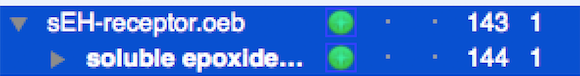

In [ ]:
from IPython.display import Image
Image('imgs/listview.png',width = 600)



I like to turn on the ribbon representation for the protein (shown below):


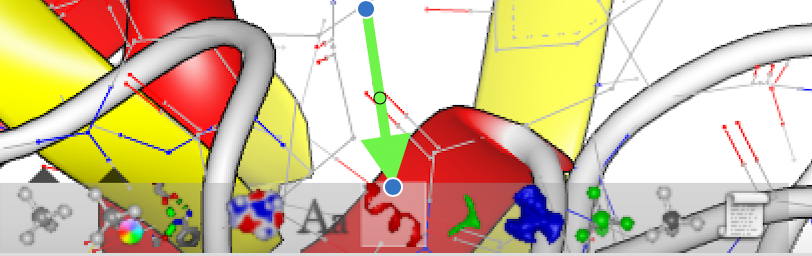

In [ ]:
Image('imgs/ribbons.png',width = 600)


Now, if you toggle the green button from the list view for the ligands, you will see the 2 docked poses generated for the selected ligand. You can also hit `Center` to move the ligand into the center view.

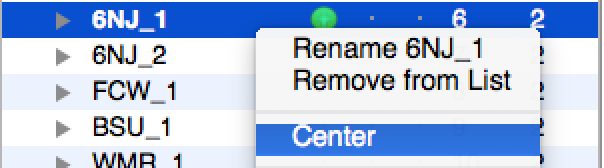

In [ ]:
Image('imgs/listligand.png',width = 400)

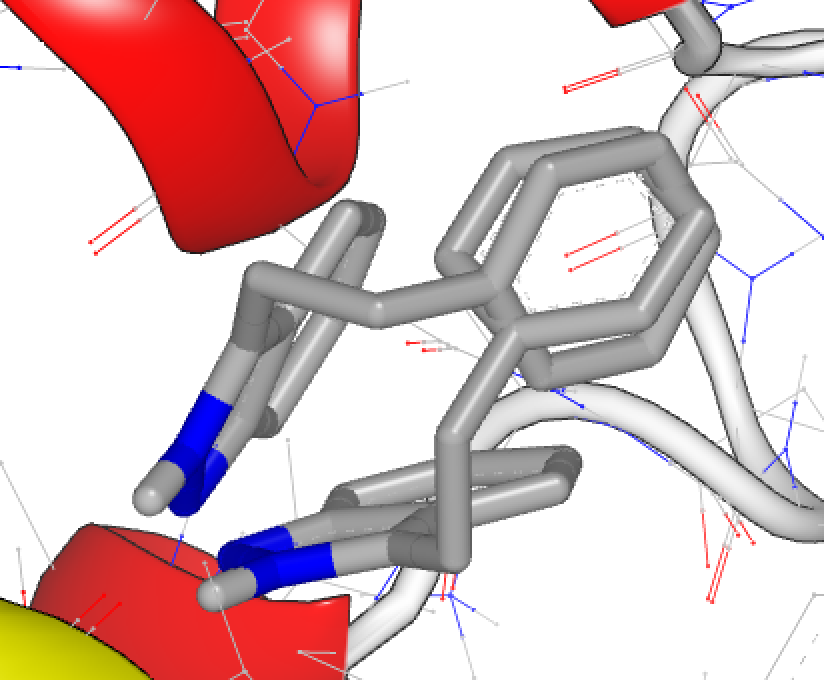

In [ ]:
Image('imgs/6NJ_1-poses.png',width = 400)

# Prep another system (the second bromodomain of PHIP2) totally from scratch

Here let's tackle an actual current/nearly current research challenge -- let's screen some compounds for potential binding to the second bromodomain of PHIP2, drawing on the [SAMPL7 protein-ligand challenge](https://github.com/samplchallenges/SAMPL7/tree/master/protein_ligand).

## First let's prep the protein using OpenEye's nice (new) Spruce toolkit

Spruce is a toolkit which handles quite a bit of protein preparation such as adding hydrogens, separating out the protein, etc. We'll discuss this in more detail down the line, but here, we'll just use it. For this, we draw on an OpenEye example at https://docs.eyesopen.com/toolkits/python/_downloads/make_design_units.py, with help/corrections from OpenEye support. Let's take the 5ENH PDB file (already placed in this directory) and prepare it as a "design unit" (a protein we want to target). The PDB contains the biological system; we want to break that up into its different components and ensure we have a single copy of the receptor we want to target, etc. Here goes: 

In [11]:
from openeye import oespruce
import tempfile
import os

def ReadFromPDB(pdb_file, mol):
    ifs = oechem.oemolistream()
    ifs.SetFlavor(oechem.OEFormat_PDB, oechem.OEIFlavor_PDB_Default | oechem.OEIFlavor_PDB_DATA | oechem.OEIFlavor_PDB_ALTLOC)  # noqa

    if not ifs.open(pdb_file):
        oechem.OEThrow.Fatal("Unable to open %s for reading." % pdb_file)

    temp_mol = oechem.OEGraphMol()
    if not oechem.OEReadMolecule(ifs, temp_mol):
        oechem.OEThrow.Fatal("Unable to read molecule from %s." % pdb_file)
    ifs.close()
    
    fact = oechem.OEAltLocationFactory(temp_mol)
    mol.Clear()
    fact.MakePrimaryAltMol(mol)
    return (mol)


bio_system_file = '5enh.pdb'

bio_system = oechem.OEGraphMol()
input_success = ReadFromPDB(bio_system_file, bio_system)
if not input_success:
    oechem.OEThrow.Fatal("Unable to input protein from PDB file.")

design_units = oespruce.OEMakeDesignUnits(bio_system)

do_write = True
temp_dir = '.' # To avoid overwrites could make this a new directory which does not exist

if do_write:
    base_name = bio_system_file[:-4]

    for i, design_unit in enumerate(design_units):
        output_design_unit_file = os.path.join(temp_dir, base_name + f"_DU_{base_name}.oedu")  # noqa
        print("\nWriting design unit {} to {}".format(i, output_design_unit_file))
        oechem.OEWriteDesignUnit(output_design_unit_file, design_unit)


Writing design unit 0 to ./5enh_DU_5enh.oedu


## Now we have our design unit; proceed to get our receptor ready

The design unit contains the receptor, any ligand, any excipients, any waters, etc. Now we need to work with those components and prepare the receptor (plus anything else we want to retain) for docking. Here, we will make a receptor for docking using everything but the bound ligand. We'll pull out the bound ligand, and separately provide it to the docking setup further below as a hint about where the binding site is:

In [12]:
# In a later release, MakeReceptor will take a "design unit"; it does not yet, so get the receptor component and use
recmol = oechem.OEGraphMol()
# Get the components excluding the ligand; could also exclude excipients and solvent depending on use case
design_unit.GetComponents(recmol, oechem.OEDesignUnitComponents_All ^ oechem.OEDesignUnitComponents_Ligand)

# If we had a bound ligand and want to use that as a hint (as we do here), we retrieve it via
bound_ligand = oechem.OEGraphMol()
design_unit.GetLigand(bound_ligand)

# Receptor file name for output
receptor_file = '5enh_prepped.oeb'
receptor = oechem.OEGraphMol()

# Prep receptor
if not os.path.isfile(receptor_file):
    # This makes a receptor using the bound ligand as a hint.
    # Lots of other hint types can be provided, such as coordinates of a binding site residue, a hint location, etc.
    oedocking.OEMakeReceptor(receptor, recmol, bound_ligand)
    oedocking.OEWriteReceptorFile(receptor, receptor_file)
else:
    #Read in our receptor from disc
    if not oedocking.OEReadReceptorFile( receptor, receptor_file ):
    # raise an exception if the receptor file cannot be read
        raise Exception("Unable to read receptor from {0}".format( receptor_file ))

## Now let's retrieve some potential ligands and prep THOSE for docking

The SAMPL7 GitHub repo has a fragment set which was experimentally screened for binding to this target via crystallography. Let's pull that set and screen it here. First we retrieve the compound list and then load it

In [13]:
import requests
import numpy as np

repo_url = 'https://raw.githubusercontent.com/samplchallenges/sampl7/master/protein_ligand/'
sources = {
    'fragments_screened.csv' : repo_url + 'fragments_screened.csv'
}

# Output filename
ligand_file = 'SAMPL7_fragments_charged.oeb.gz'

for (filename, url) in sources.items():
    r = requests.get(url)
    open(filename, 'w').write(r.text)

# Read text from file
file = open('fragments_screened.csv')
text = file.readlines()
file.close()

# Process to dictionary, with SMILES strings keyed by fragment name
fragments_screened = {}
for line in text:
    tmp = line.split(',')
    fragments_screened[tmp[0]] = tmp[1].strip()

### Now we'll prep our ligands for docking

To prepare our ligands for docking, we need to generate conformers for them, then compute partial charges for each. **This is the most expensive step in this notebook.**

We'll then store them to an `.oeb.gz` file so they don't take much space. Here, we generate conformers and store them. There are about 799 molecules and on Colab this took me about 20 minutes to run.

In [14]:
import openeye.oeomega as oeomega
import openeye.oequacpac as oequacpac
import openeye.oechem as oechem

#Skip charging? Charging each molecule can take a few seconds or more, and there are 800 here, 
# so charging will take a while to charge them
skipcharging = False

if not os.path.isfile(ligand_file):
    # Initialize Omega
    omega = oeomega.OEOmega()
    omega.SetMaxConfs(100)
    omega.SetStrictStereo(False) # Pick random stereoisomer if not specified

    # Loop over molecules, make OE molecules, generate conformers
    oemols = []
    for mol_id in fragments_screened:
        print(mol_id)
        # Create new OEMol, set its title, parse from SMILES
        mol = oechem.OEMol()
        mol.SetTitle(mol_id)
        oechem.OEParseSmiles(mol, fragments_screened[mol_id])

        # Store fragment ID as SD data just to make sure it sticks around
        oechem.OESetSDData(mol, 'SAMPL7 fragment ID', mol_id)

        # Generate conformers
        omega(mol)

        # Compute charges if desired
        if not skipcharging:
            oequacpac.OEAssignCharges(mol, oequacpac.OEAM1BCCELF10Charges())

        # Store mol
        oemols.append(mol)
    
    # Write our charged molecules
    with oechem.oemolostream( ligand_file) as ofs:
        #Loop over 3D molecules we charged and write
        for mcmol in oemols:
            #Write charged molecules to output filestream
            oechem.OEWriteMolecule(ofs, mcmol)
            
    #ofs.close()

F1
F2
F3
F4
F5
F6
F7
F8
F9
F10
F11
F12
F13
F14
F15
F16
F17
F18
F19
F20
F21
F22
F23
F24
F25
F26
F27
F28
F29
F30
F31
F32
F33
F34
F35
F36
F37
F38
F39
F40
F41
F42
F43
F44
F45
F46
F47
F48
F49
F50
F51
F52
F53
F54
F55
F56
F57
F58
F59
F60
F61
F62
F63
F64
F65
F66
F67
F68
F69
F70
F71
F72
F73
F74
F75
F76
F77
F78
F79
F80
F81
F82
F83
F84
F85
F86
F87
F88
F89
F90
F91
F92
F93
F94
F95
F96
F97
F98
F99
F100
F101
F102
F103
F104
F105
F106
F107
F108
F109
F110
F111
F112
F113
F114
F115
F116
F117
F118
F119
F120
F121
F122
F123
F124
F125
F126
F127
F128
F129
F130
F131
F132
F133
F134
F135
F136
F137
F138
F139
F140
F141
F142
F143
F144
F145
F146
F147
F148
F149
F150
F151
F152
F153
F154
F155
F156
F157
F158
F159
F160
F161
F162
F163
F164
F165
F166
F167
F168
F169
F170
F171
F172
F173
F174
F175
F176
F177
F178
F179
F180
F181
F182
F183
F184
F185
F186
F187
F188
F189
F190
F191
F192
F193
F194
F195
F196
F197
F198
F199
F200
F201
F202
F203
F204
F205
F206
F207
F208
F209
F210
F211
F212
F213
F214
F215
F216
F217
F218
F219
F220
F221
F22

## Next we go ahead and do docking, like we do above!

This docks the list of compounds we loaded above which have been experimentally screened for binding.

Because of all the preparation of the receptor and the individual compounds, docking is not an extremely slow step. On Colab for me this takes about ... minutes.

In [15]:
#Define file path and initialize receptor variable
receptor_file = '5enh_prepped.oeb'
docked_file = 'SAMPL7_fragments_docked.oeb.gz'
receptor = oechem.OEGraphMol()

#Read in our receptor from disc
if not oedocking.OEReadReceptorFile( receptor, str( receptor_file ) ):
    # raise an exception if the receptor file cannot be read
    raise Exception("Unable to read receptor from {0}".format( receptor_file ))
    
#Set the docking method and other paramters
# Note: Chemgauss4 is the scoring function for FRED
dock_method = oedocking.OEDockMethod_Chemgauss4
dock_resolution = oedocking.OESearchResolution_Default
sdtag = oedocking.OEDockMethodGetName( dock_method )

#Generate our OEDocking object
dock = oedocking.OEDock( dock_method, dock_resolution)

#Initialize the OEDocking by providing it the receptor
if not dock.Initialize(receptor):
    # raise an exception if the receptor cannot be initialized
    raise Exception("Unable to initialize Docking with {0}".format(self.args.receptor))
    
#Define how many docked poses to generate per molecule
num_poses = 2

#Read in our 3D molecules 
ifs = oechem.oemolistream( ligand_file )
ofs = oechem.oemolostream( docked_file )

#Loop over 3D molecules from the input filestream
for mcmol in ifs.GetOEMols():
#for mcmol in oemols:
    #Call our docking function
    # Print score
    dockedMol, score = dock_molecule( dock, sdtag, num_poses, mcmol )
    print("{} {} score = {:.4f}".format(sdtag, dockedMol.GetTitle(), score))

    #Write docked molecules to output filestream
    oechem.OEWriteMolecule(ofs, dockedMol)
ifs.close()
ofs.close()

Chemgauss4 F1 score = -6.2625
Chemgauss4 F2 score = -8.0827
Chemgauss4 F3 score = -7.5390
Chemgauss4 F4 score = -7.4861
Chemgauss4 F5 score = -7.5767
Chemgauss4 F6 score = -7.7025
Chemgauss4 F7 score = -6.5838
Chemgauss4 F8 score = -7.7699
Chemgauss4 F9 score = -6.4692
Chemgauss4 F10 score = -6.6869
Chemgauss4 F11 score = -6.8318
Chemgauss4 F12 score = -6.9026
Chemgauss4 F13 score = -6.7557
Chemgauss4 F14 score = -6.4353
Chemgauss4 F15 score = -6.4905
Chemgauss4 F16 score = -6.2669
Chemgauss4 F17 score = -4.9167
Chemgauss4 F18 score = -9.5034
Chemgauss4 F19 score = -8.3157
Chemgauss4 F20 score = -7.4964
Chemgauss4 F21 score = -9.6819
Chemgauss4 F22 score = -10.1780
Chemgauss4 F23 score = -7.2314
Chemgauss4 F24 score = -6.7360
Chemgauss4 F25 score = -8.3577
Chemgauss4 F26 score = -6.1770
Chemgauss4 F27 score = -6.7257
Chemgauss4 F28 score = -7.7082
Chemgauss4 F29 score = -7.9831
Chemgauss4 F30 score = -7.3170
Chemgauss4 F31 score = -8.7202
Chemgauss4 F32 score = -8.4609
Chemgauss4 F33 s

## OK, so now we've docked them... What would be next?

Now we've scored and docked all of the molecules. We could then use the ranked list to pick which compounds are most likely to bind, and then compare this to the actual list of binders from the SAMPL7 challenge to see how we did.

We will leave this as an exercise to the user; the list of actual hits (actual binders) is available on the [SAMPL7 GitHub repository](https://github.com/samplchallenges/SAMPL7/tree/master/protein_ligand/experimental-data/stage-1), and in particular you would be comparing your predictions with the "all sites" binding in the last column of this file: https://github.com/samplchallenges/SAMPL7/blob/master/protein_ligand/experimental-data/stage-1/hits_verification.csv

# Acknowledgements

- Authors: Meghan Osato, Nathan M. Lim, David L. Mobley
- OpenEye and Spruce help from Jesper Sorensen